__Market Response Model__
Segmenting customers and doing A/B tests enable us to try lots of different ideas for generating incremental sales. This is one of the building blocks of Growth Hacking. You need to ideate and experiment continuously to find growth opportunities.
Splitting the customers who we are going to send the offer into test and control groups helps us to calculate incremental gains.

This kind of setup answers the following questions about target group:-
- Does giving an offer increase conversion 
- if yes, what kind of offer performs the best? Discount or buy one get one ?
From the above figure if the results are statistically different it looks like discount works the best as it is bringing 
3% more conversion as compared to no offer while buy one get one brought only 1% more conversion as compared to no offer.

However, in the real world different offers tends to perform differently with different segments. We need to create a portfolio
of offers for selected segments. Also conversion is not the only criteria to determine the best strategy, their is always a cost
trade-off and their is a cost associated with each offer. Thats why sometimes we need to select an offer that is cost friendly
but brings lower conversions.

Market response models helps to build a framework in order to predict the outcome of an offer we are providing, this helps to 
maximize our transactions and gives a forecast of our cost.However there is one more way of doing it:-
- If you don’t have a control group (imagine you did an open promotion to everyone and announced it on social media), then you cannot calculate the incrementality. For this kind of situation, better to build a regression model that predicts overall sales. The prior assumption will be that the model will provide higher sales numbers for the promo days.
    To build this kind of model, your dataset should include promo & non-promo days sales numbers so that the machine learning model can calculate the incrementality.
- If you have a control group, you can build the response model based on segment or individual level. For both of them, the assumption is the same. Giving an offer should increase the probability of conversion. The uptick in the individuals’ conversion probability will bring us the incremental conversion.

In [2]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb

In [3]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
recency          64000 non-null int64
history          64000 non-null float64
used_discount    64000 non-null int64
used_bogo        64000 non-null int64
zip_code         64000 non-null object
is_referral      64000 non-null int64
channel          64000 non-null object
offer            64000 non-null object
conversion       64000 non-null int64
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [6]:
df.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0
8,9,675.07,1,1,Rural,1,Phone,Discount,0
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0


Our first 8 columns are providing individual-level data and conversion column is our label to predict:
- recency: months since last purchase
- history: $value of the historical purchases
- used_discount/used_bogo: indicates if the customer used a discount or buy one get one before
- zip_code: class of the zip code as Suburban/Urban/Rural
- is_referral: indicates if the customer was acquired from referral channel
- channel: channels that the customer using, Phone/Web/Multichannel
- offer: the offers sent to the customers, Discount/But One Get One/No Offer

We will be building a binary classification model for scoring the conversion probability of all customers. For doing that, we are going to follow the steps below:
- Building the uplift formula
- Exploratory Data Analysis (EDA) & Feature Engineering
- Scoring the conversion probabilities
- Observing the results on the test set

Assumption - Every order means 1 order and each order is of value 25$

__Uplift Formula__<br></br>

We will calculate three uplifts:-
- Conversion uplift = conversion of test group - conversion of control group
- Order uplift = Conversion uplift* No. of converted customers in test group
- Revenue uplift = Order Uplift*Revenue generated per order in test group

In [7]:
def uplift(df):
    base_conv = np.round(df[df.offer=='No Offer']['conversion'].mean(),2)
    disc_conv = np.round(df[df.offer=='Discount']['conversion'].mean(),2)
    bogo_conv = np.round(df[df.offer=='Buy One Get One']['conversion'].mean(),2)
    disc_order_Uplift = np.round(disc_conv*len(df[df.offer=='Discount']['conversion']),2)
    bogo_order_uplift = np.round(bogo_conv*len(df[df.offer=='Buy One Get One']['conversion']),2)
    disc_revenue_uplift = disc_order_Uplift*25
    bogo_revenue_uplift = bogo_order_uplift*25
    print(f'Base conversion {base_conv}')
    print(f'Discount conversion {disc_conv}')
    print(f'Buy One Get One conversion {bogo_conv}')
    print(f'Discount Order Uplift {disc_order_Uplift}')
    print(f'Buy One Get One Order Uplift {bogo_order_uplift}')
    print(f'Discount Revenue Uplift {disc_revenue_uplift}')
    print(f'Buy One Get One Revenue uplift {bogo_revenue_uplift}') 

uplift(df)

Base conversion 0.11
Discount conversion 0.18
Buy One Get One conversion 0.15
Discount Order Uplift 3835.26
Buy One Get One Order Uplift 3208.05
Discount Revenue Uplift 95881.5
Buy One Get One Revenue uplift 80201.25


In [8]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.conversion.mean()

0.14678125

In [10]:
def calc_uplift(df):
    #assigning 25$ to the average order value
    avg_order_value = 25
    
    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()
    
    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.offer == 'Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer == 'Buy One Get One']['conversion'])
    
    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    
    
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
          
    print('-------------- \n')

    print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
    print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
    print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))


In [11]:
calc_uplift(df)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


__Exploratory Data Analysis__

__Recency__

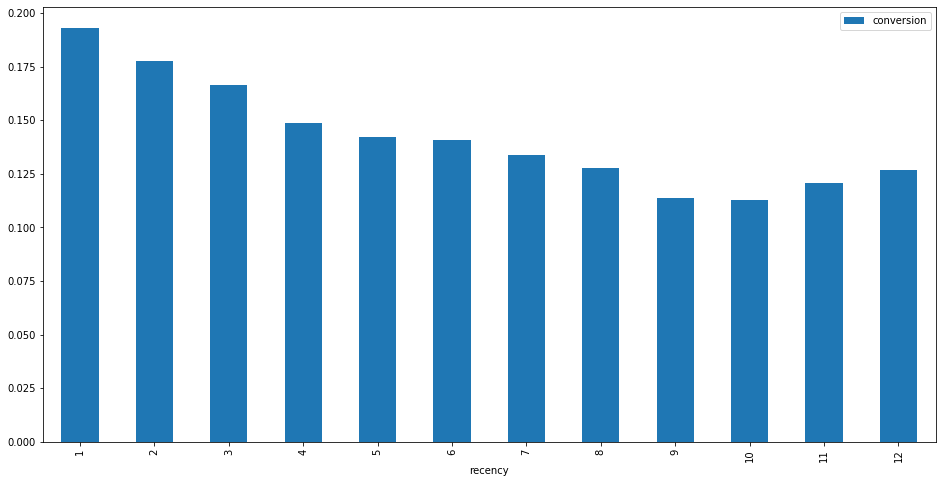

In [14]:
df_plot = df.groupby('recency').conversion.mean().reset_index()
fig, ax = plt.subplots(figsize=(16,8))
df_plot.plot(x='recency',y='conversion',kind ='bar',ax=ax)
plt.show()

__History__

In [15]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df[['history']])
df['history_cluster'] = kmeans.predict(df[['history']])

In [16]:
df = order_cluster('history_cluster', 'history',df,True)
df.groupby('history_cluster').agg({'history':['mean','min','max'], 'conversion':['count', 'mean']})

history                   conversion          
                        mean      min      max      count      mean
history_cluster                                                    
0                  73.677511    29.99   159.59      32192  0.122639
1                 245.275233   159.62   360.31      17925  0.159386
2                 475.004243   360.34   640.27       9132  0.180683
3                 805.650338   640.39  1104.97       3819  0.193244
4                1406.201277  1106.14  3345.93        932  0.215665

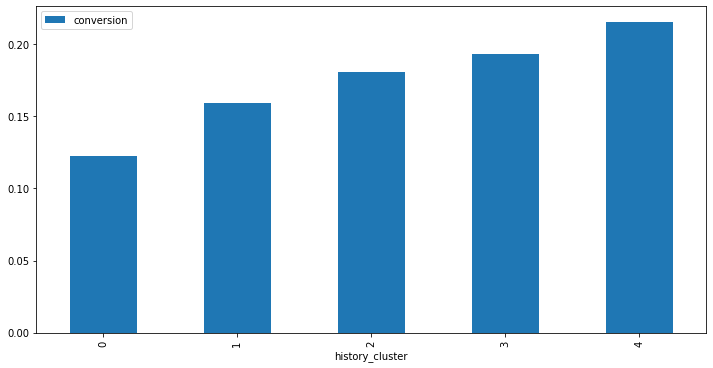

In [19]:
df_plot = df.groupby('history_cluster').conversion.mean().reset_index()
fig, ax = plt.subplots(figsize=(12,6))
df_plot.plot(x='history_cluster',y='conversion',kind ='bar',ax=ax)
plt.show()

__Used Discount & BOGO__

In [22]:
df.groupby(['used_discount','offer']).agg({'conversion':'mean'})

conversion
used_discount offer                      
0             Buy One Get One    0.169794
              Discount           0.166388
              No Offer           0.095808
1             Buy One Get One    0.136286
              Discount           0.196098
              No Offer           0.114533

In [23]:
df.groupby(['used_bogo','offer']).agg({'conversion':'mean'})

conversion
used_bogo offer                      
0         Buy One Get One    0.110892
          Discount           0.168968
          No Offer           0.099813
1         Buy One Get One    0.184530
          Discount           0.193974
          No Offer           0.111416

In [28]:
df_plot = df.groupby(['used_discount','used_bogo','offer']).agg({'conversion':'mean'})
df_plot

conversion
used_discount used_bogo offer                      
0             1         Buy One Get One    0.169794
                        Discount           0.166388
                        No Offer           0.095808
1             0         Buy One Get One    0.110892
                        Discount           0.168968
                        No Offer           0.099813
              1         Buy One Get One    0.251653
                        Discount           0.314993
                        No Offer           0.180549

<Figure size 720x360 with 0 Axes>

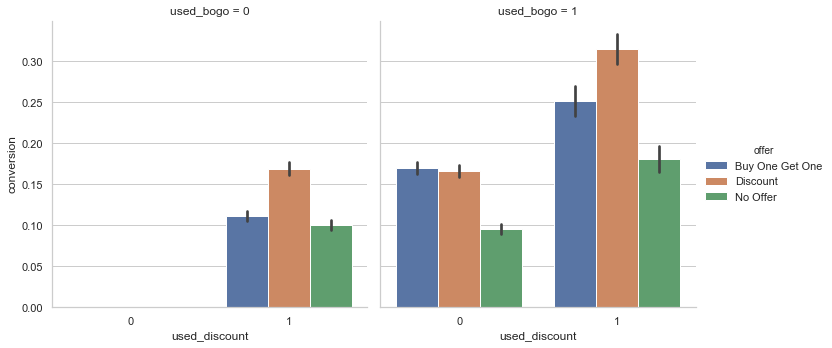

In [62]:
plt.figure(figsize=(10,5))
sns.set(style="whitegrid", color_codes=True)
sns.catplot(x='used_discount',y='conversion',hue='offer',col='used_bogo',data=df,kind='bar')
plt.show() 

__Zip Code__

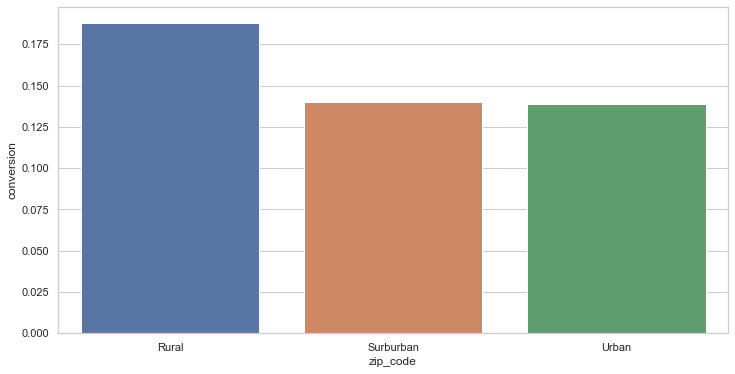

In [65]:
df_plot = df.groupby('zip_code').conversion.mean().reset_index()
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='zip_code',y='conversion',data=df_plot,ax=ax)
plt.show()

__Referral__

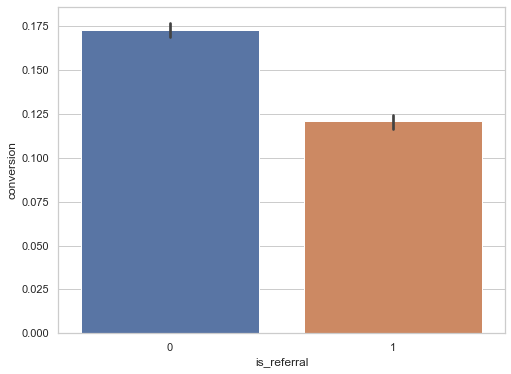

In [71]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='is_referral',y='conversion',data=df,ax=ax)
plt.show()

__Channel__

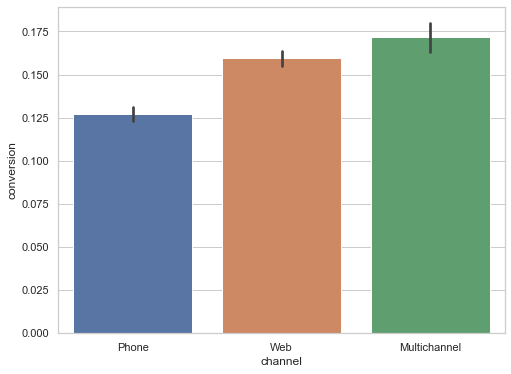

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='channel',y='conversion',data=df,ax=ax)
plt.show()

__Offer__

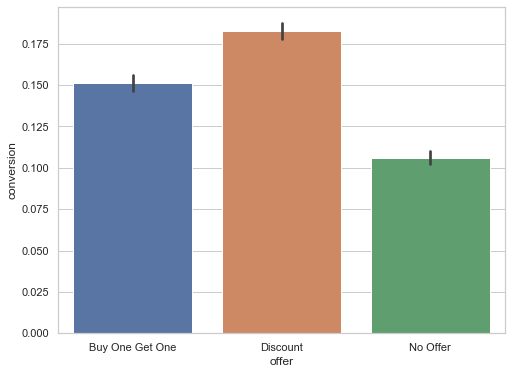

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='offer',y='conversion',data=df,ax=ax)
plt.show()

In [31]:
df_model = df.copy()
df_model = pd.get_dummies(df_model)

In [32]:
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,conversion,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer
0,10,142.44,1,0,0,0,0,0,1,0,0,1,0,1,0,0
1,2,45.34,1,0,0,0,0,0,0,1,0,0,1,1,0,0
2,6,134.83,0,1,0,1,0,0,1,0,0,1,0,1,0,0
3,9,46.42,0,1,0,0,0,0,0,1,0,1,0,1,0,0
4,10,32.84,0,1,1,0,0,0,0,1,0,0,1,1,0,0


In [33]:
df_model.conversion.mean()

0.14678125

In [34]:
#create feature set and labels
X = df_model.drop(['conversion'],axis=1)
y = df_model.conversion

In [35]:
X.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
       'history_cluster', 'zip_code_Rural', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Multichannel', 'channel_Phone',
       'channel_Web', 'offer_Buy One Get One', 'offer_Discount',
       'offer_No Offer'],
      dtype='object')

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
X_test['proba'] = xgb_model.predict_proba(X_test)[:,1]

C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
X_test.head(5)

,recency,history,used_discount,used_bogo,is_referral,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer,proba
32277,10,335.77,0,1,0,1,1,0,0,1,0,0,1,0,0,0.211362
12824,3,29.99,1,0,1,0,0,0,1,0,0,1,0,0,1,0.074472
20159,5,142.32,0,1,0,0,0,1,0,0,0,1,0,1,0,0.191981
41575,4,214.78,0,1,1,1,0,0,1,0,1,0,0,0,1,0.061653
10736,9,89.55,0,1,1,0,0,1,0,0,0,1,0,1,0,0.112507


In [38]:
X_test.proba.mean()

0.146456778049469

In [39]:
y_test.mean()

0.14890625

In [40]:
X_test['conversion'] = y_test

C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
X_test[X_test['offer_Buy One Get One'] == 1].conversion.mean()

0.15043638033991732

In [42]:
X_test[X_test['offer_Buy One Get One'] == 1].proba.mean()

0.1534760594367981

In [43]:
X_test[X_test['offer_Discount'] == 1].conversion.mean()

0.1910722720831365

In [44]:
X_test[X_test['offer_Discount'] == 1].proba.mean()

0.17825019359588623

In [45]:
X_test[X_test['offer_No Offer'] == 1].conversion.mean()

0.10493827160493827

In [46]:
X_test[X_test['offer_No Offer'] == 1].proba.mean()

0.10724073648452759

In [47]:
real_disc_uptick = int(len(X_test)*(X_test[X_test['offer_Discount'] == 1].conversion.mean() - X_test[X_test['offer_No Offer'] == 1].conversion.mean()))
pred_disc_uptick = int(len(X_test)*(X_test[X_test['offer_Discount'] == 1].proba.mean() - X_test[X_test['offer_No Offer'] == 1].proba.mean()))

In [48]:
print('Real Discount Uptick - Order: {}, Revenue: {}'.format(real_disc_uptick, real_disc_uptick*25))
print('Predicted Discount Uptick - Order: {}, Revenue: {}'.format(pred_disc_uptick, pred_disc_uptick*25))

Real Discount Uptick - Order: 1102, Revenue: 27550
Predicted Discount Uptick - Order: 908, Revenue: 22700


In [49]:
real_bogo_uptick = int(len(X_test)*(X_test[X_test['offer_Buy One Get One'] == 1].conversion.mean() - X_test[X_test['offer_No Offer'] == 1].conversion.mean()))

pred_bogo_uptick = int(len(X_test)*(X_test[X_test['offer_Buy One Get One'] == 1].proba.mean() - X_test[X_test['offer_No Offer'] == 1].proba.mean()))

In [50]:
print('Real Discount Uptick - Order: {}, Revenue: {}'.format(real_bogo_uptick, real_bogo_uptick*25))
print('Predicted Discount Uptick - Order: {}, Revenue: {}'.format(pred_bogo_uptick, pred_bogo_uptick*25))

Real Discount Uptick - Order: 582, Revenue: 14550
Predicted Discount Uptick - Order: 591, Revenue: 14775
